In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
import os
os.chdir('/content/drive/MyDrive/K-D_Tree_NeRF/diffusion-point-cloud')

Mounted at /content/drive/


In [2]:
!pip install open3d
os.chdir('/content/drive/MyDrive/K-D_Tree_NeRF/diffusion-point-cloud/pcd_ordering')
!python setup.py build_ext --inplace
import PyKDTree
os.chdir('/content/drive/MyDrive/K-D_Tree_NeRF/diffusion-point-cloud')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
running build_ext


In [3]:
import os
import math
import argparse
import torch
import torch.utils.tensorboard
from torch.utils.data import DataLoader
from torch.nn.utils import clip_grad_norm_
from tqdm.auto import tqdm

from utils.dataset import *
from utils.misc import *
from utils.data import *
from models.flow import add_spectral_norm, spectral_norm_power_iteration
from evaluation import *
from models.vae_trained_z import MyVAE

# src_path = '../pcd_gen_results/pcd_gen1_ckpts/GEN_2022_10_14__08_37_36/ckpt_0.000000_629999.pt'
# src_path = '../pcd_gen_results/pcd_gen2_ckpts/GEN_2022_10_14__08_28_48/ckpt_0.000000_629999.pt'
src_path = '../pcd_gen_results/hotdog-chair_1021/ckpt_0.000000_299999.pt'
ckpt = torch.load(src_path)

model = MyVAE(ckpt['args']).cuda()
model.load_state_dict(ckpt['state_dict'])

<All keys matched successfully>

In [4]:
ratios = torch.tensor([0.0, 0.25, 0.375, 0.40625, 0.4375, 0.5, 0.5625, 0.59375, 0.625, 0.75, 1]).cuda()
ratios.shape

torch.Size([11])

In [5]:
def align_pcds(points_ref, points_src, index=None):
  # index is with points_src
  tree = PyKDTree.PyKDTree(points_ref.astype(np.double), points_src.astype(np.double))
  tree.build(1, 1, points_ref.shape[0], 0)
  index_ref, index_src = tree.output_index()
  modified_points = points_src[index_src][np.argsort(index_ref)]
  return_index = index
  if not (index is None):
    return_index = return_index[index_src][np.argsort(index_ref)]

  return modified_points, return_index

  0%|          | 0/11 [00:00<?, ?it/s]

torch.Size([1, 2000000, 3])


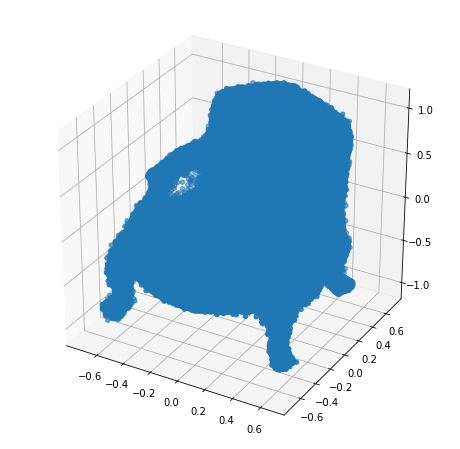

  9%|▉         | 1/11 [01:42<17:01, 102.14s/it]

torch.Size([1, 2000000, 3])


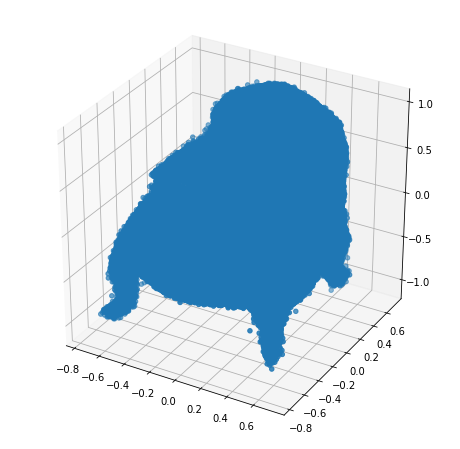

 18%|█▊        | 2/11 [03:25<15:28, 103.13s/it]

torch.Size([1, 2000000, 3])


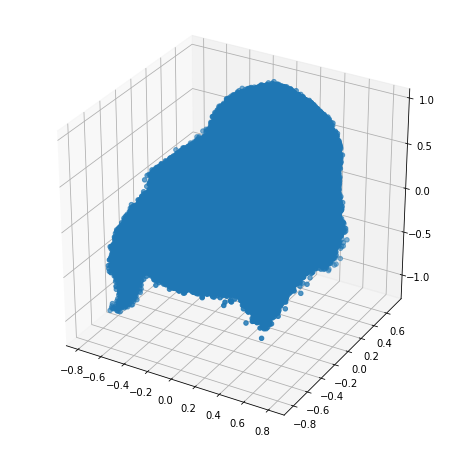

 27%|██▋       | 3/11 [05:11<13:55, 104.40s/it]

torch.Size([1, 2000000, 3])


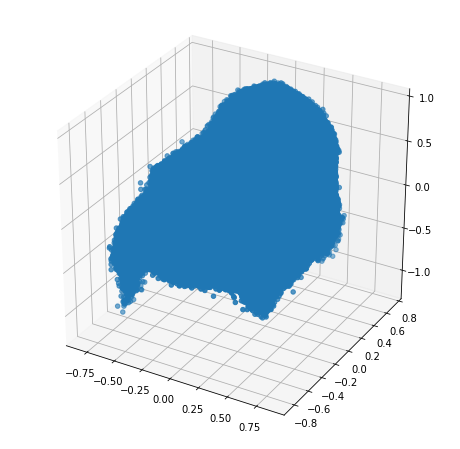

 36%|███▋      | 4/11 [06:57<12:14, 104.99s/it]

torch.Size([1, 2000000, 3])


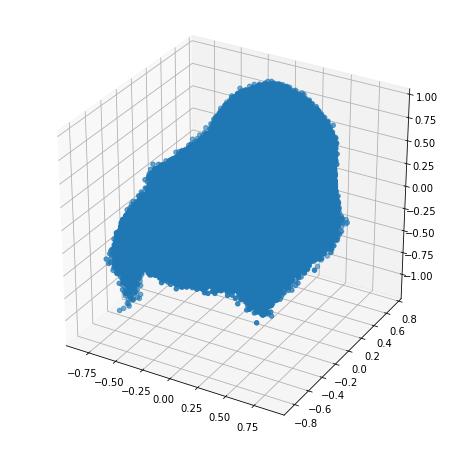

 45%|████▌     | 5/11 [08:43<10:30, 105.13s/it]

torch.Size([1, 2000000, 3])


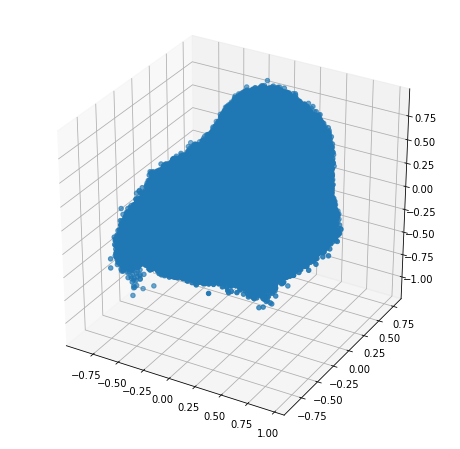

 55%|█████▍    | 6/11 [10:27<08:45, 105.01s/it]

torch.Size([1, 2000000, 3])


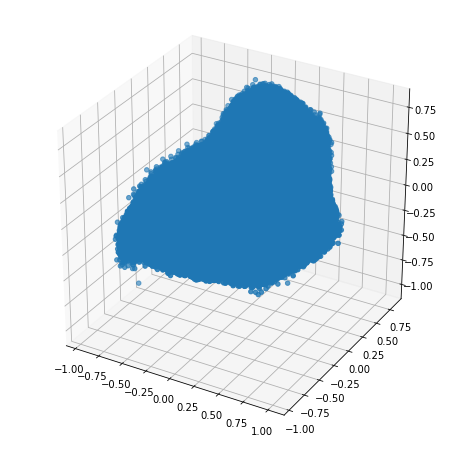

 64%|██████▎   | 7/11 [12:12<06:59, 104.91s/it]

torch.Size([1, 2000000, 3])


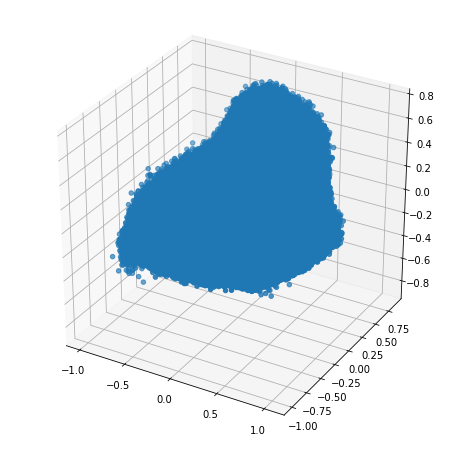

 73%|███████▎  | 8/11 [13:58<05:15, 105.13s/it]

torch.Size([1, 2000000, 3])


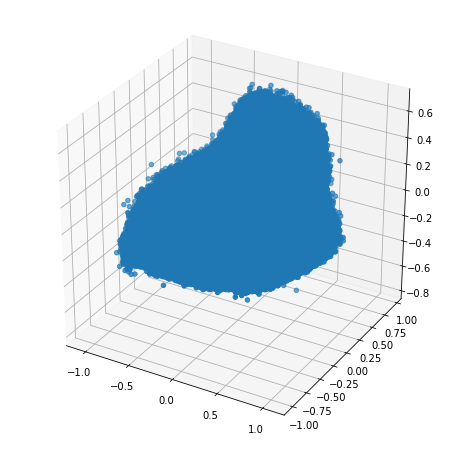

 82%|████████▏ | 9/11 [15:44<03:30, 105.41s/it]

torch.Size([1, 2000000, 3])


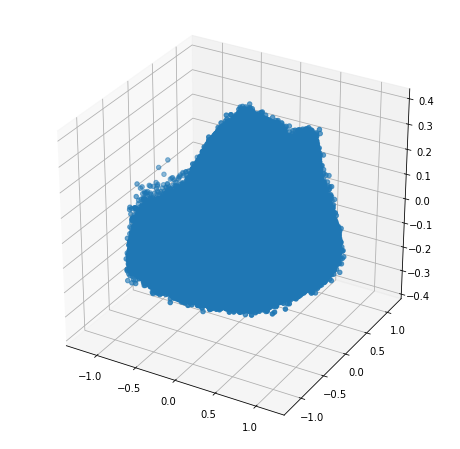

 91%|█████████ | 10/11 [17:31<01:45, 105.88s/it]

torch.Size([1, 2000000, 3])


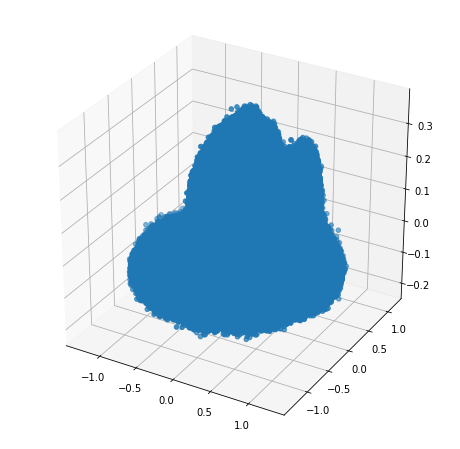

100%|██████████| 10/10 [00:24<00:00,  2.48s/it]


In [6]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import open3d as o3d

np_pcds = []
indexs = []
clouds = []

id_list = np.array(range(ratios.shape[0]))
with torch.no_grad():
  for id in tqdm(id_list):
    interpolate_samples = model.sample_interpolate(num=2000000, ratios=ratios[id:id+1])
    print(interpolate_samples.shape)

    pts = interpolate_samples.detach().cpu()
    del interpolate_samples

    torch.cuda.empty_cache()
    torch.cuda.empty_cache()
    torch.cuda.empty_cache()
    torch.cuda.empty_cache()

    np_pcd = pts[0].numpy()
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(np_pcd[:,0], np_pcd[:,1], np_pcd[:,2])
    plt.show()
    np_pcds.append(np_pcd)

clouds.append(np_pcds[0])
for i in tqdm(range(1, len(np_pcds))):
  np_pcd, _ = align_pcds(clouds[i-1], np_pcds[i])
  clouds.append(np_pcd)
for cloud in clouds:
  pcd = o3d.geometry.PointCloud()
  pcd.points = o3d.utility.Vector3dVector(cloud)
  _, index = pcd.remove_statistical_outlier(nb_neighbors=64, std_ratio=4.5)
  indexs.append(index)

In [7]:
index_0 = np.load('../diffusion-point-cloud/data/PG_hc_index/chair_index.npy')
index_1 = np.load('../diffusion-point-cloud/data/PG_hc_index/hotdog_index.npy')
print(index_0.shape, index_1.shape)

_, ordered_index_0 = align_pcds(clouds[0], model.point_clouds[0].detach().cpu().numpy(), index_0)
_, ordered_index_1 = align_pcds(clouds[-1], model.point_clouds[1].detach().cpu().numpy(), index_1)

(2000000,) (2000000,)


In [8]:
save_dict = {'points':torch.tensor(np.array(clouds)), 'index':indexs, 'ordered_index_0':ordered_index_0, 'ordered_index_1':ordered_index_1, 'ratios':ratios.detach().cpu()}
torch.save(save_dict, './hotdog-chair_1023_pcd_order.pth')

In [9]:
print(len(save_dict['index']))
print(save_dict['points'].shape)

11
torch.Size([11, 2000000, 3])


In [11]:
%matplotlib inline
def plot(pts, pro=None, rgb=None, recenter=True, pov=[0], revcol=[False]):
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    import matplotlib.gridspec as gridspec
    import numpy as np
    import torch

    if len(pts.shape) > 2:
        pts = pts.squeeze(0)
        if pro is not None:
            pro = pro.squeeze(0)
        if rgb is not None:
            rgb = rgb.squeeze(0)
    
    if pro is None:
        pro = torch.ones_like(pts[:, 0])
    if rgb is None:
        rgb = torch.zeros_like(pts)

    assert len(pts.shape) == 2

    pts = pts.clone().cpu().numpy()
    x, y, z = pts[:,0], pts[:,1], pts[:,2]
    if recenter:
        x -= x.mean()
        y -= y.mean()
        z -= z.mean()
    
    for rc in revcol:
        rgba = torch.cat([rgb if not rc else 1 - rgb, pro.unsqueeze(-1)], dim=-1).cpu().numpy()

        for i in pov:
            fig = plt.figure(dpi=200)
            # gs = gridspec.GridSpec(nrows=4, ncols=2, left=0.1, right=2.5, wspace=0.05, hspace=0.1, bottom=0.1, top=4.9)
            gs = gridspec.GridSpec(nrows=1, ncols=1, left=0.05, right=4, wspace=0.05, hspace=0.05, bottom=0.0, top=4)
        
            ax = fig.add_subplot(gs[0, 0], projection='3d')
            if not rc:
                pane_col = (0., 0., 0.5, 0.1)
            else:
                pane_col = (0., 0., 0., 0.95)
            ax.xaxis.set_pane_color(pane_col)
            ax.yaxis.set_pane_color(pane_col)
            ax.zaxis.set_pane_color(pane_col)

            x, y, z = pts[:,0], pts[:,1], pts[:,2]
            labx, laby, labz = 'x', 'y', 'z'
            if (i & 4) != 0:    x = -x; labx = '-x'
            if (i & 2) != 0:    y = -y; laby = '-y'
            if (i & 1) != 0:    z = -z; labz = '-z'

            lmin = min(x.min(), y.min(), z.min())
            lmax = max(x.max(), y.max(), z.max())
            ax.scatter(x, y, z, c=rgba, marker='.')

            ax.set_xlim(lmin, lmax)
            ax.set_ylim(lmin, lmax)
            ax.set_zlim(lmin, lmax)

            ax.set_xlabel(labx)
            ax.set_ylabel(laby)
            ax.set_zlabel(labz)
            plt.show()

In [10]:
def contour_rgb(pts):
  r = np.array([1, 0, 0])
  g = np.array([0, 1, 0])
  b = np.array([0, 0, 1])
  z = pts[:, 2].copy()
  min = np.min(z)
  max = np.max(z)
  z = ((z - min) / (max - min))[...,np.newaxis]
  c0 = (z - 0/2) * g + (1/2 - z) * b
  c1 = (z - 1/2) * r + (2/2 - z) * g
  c0 *= 2
  c1 *= 2
  rgb = np.where(np.repeat(z, 3, axis=-1) < 0.5, c0, c1)
  return rgb


clouds = []
clouds.append(np_pcds[0])
for i in range(1, len(np_pcds)):
  np_pcd, _ = align_pcds(clouds[i-1], np_pcds[i])
  clouds.append(np_pcd)

fix_rgb = contour_rgb(clouds[10])
for i, cloud in enumerate(clouds):
    print(i)
    np.random.seed(114514)
    randperm = np.random.choice(cloud.shape[0], cloud.shape[0], replace=False)
    plot(torch.tensor(cloud[randperm]), rgb=torch.tensor(fix_rgb[randperm]))

0


NameError: ignored

In [13]:
max_cor = np.max(clouds[10], axis=0)
min_cor = np.min(clouds[10], axis=0)
eps = 0.2
fix_rgb = (clouds[10] - min_cor) / (max_cor - min_cor) * (1-eps) + eps

for i, cloud in enumerate(clouds):
    print(i)
    np.random.seed(114514)
    randperm = np.random.choice(cloud.shape[0], cloud.shape[0], replace=False)
    plot(torch.tensor(cloud[randperm]), rgb=torch.tensor(fix_rgb[randperm]))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

num = 4
with torch.no_grad():
  interpolate_samples = model.sample_interpolate(num=2000000, ratios=ratios[5:6])
  print(interpolate_samples.shape)

pts = interpolate_samples.detach().cpu()
del interpolate_samples

np_pcd = pts[0].numpy()
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(np_pcd[:,0], np_pcd[:,1], np_pcd[:,2])
plt.show()

In [ ]:
def kd_index(points):
  tree = PyKDTree.PyKDTree(points.astype(np.double))
  tree.build(1, 1, points.shape[0], 0)
  index = np.argsort(tree.output_index())

  return index

def order_pts(points, ori_index=None):
  tree = PyKDTree.PyKDTree(points.astype(np.double))
  tree.build(1, 1, points.shape[0], 0)
  index = tree.output_index()
  return_index = ori_index
  if not (return_index is None):
    return_index = return_index[index]

  return points[index], return_index

In [ ]:
np.random.seed(114514)
random_index = np.random.choice(2000000, 2**20, replace=False)
index_0 = np.load('../diffusion-point-cloud/data/PG_hc_index/chair_index.npy')
index_1 = np.load('../diffusion-point-cloud/data/PG_hc_index/hotdog_index.npy')
print(index_0.shape, index_1.shape)

_, ordered_index_0 = order_pts(model.point_clouds[0].detach().cpu().numpy(), index_0)
_, ordered_index_1 = order_pts(model.point_clouds[1].detach().cpu().numpy(), index_1)

(2000000,) (2000000,)


In [ ]:
np_pts = pts.numpy()
pts_0 = np_pts[0]
max_cor = np.max(pts_0, axis=0)
min_cor = np.min(pts_0, axis=0)
eps = 0.2
colors_0 = (pts_0 - min_cor) / (max_cor - min_cor) * (1-eps) + eps

In [ ]:
import open3d as o3d

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pts_0)

In [ ]:
cl, index = pcd.remove_radius_outlier(nb_points=10, radius=0.08)

In [ ]:
np.array(index).shape

(524216,)